In [3]:
"""
This script is designed to do batch regridf of the 
regional mom6 output usig the new mom6_read module

The regridding is using the xesmf package with the bilinear method
there are other more conservative way to doing the regriddeding 
https://xesmf.readthedocs.io/en/stable/notebooks/Compare_algorithms.html 
"""
import os
import warnings
import xarray as xr
from mom6.data_structure import portal_data
from mom6.mom6_module.mom6_read import AccessFiles
from mom6.mom6_module.mom6_regrid import Regridding
from mom6.mom6_module.mom6_export import mom6_encode_attr

warnings.simplefilter("ignore")



In [7]:
dict_json = {
    "local_top_dir": "/Projects/CEFI/regional_mom6/",
    "region": "northwest_atlantic",
    "subdomain": "full_domain",
    "experiment_type": "hindcast",
    "output_frequency": "monthly",
    "grid_type": "raw",
    "release": "r20230520",
    "data_source": "local",
    "output": {
        "cefi_grid_type": "regrid",
        "cefi_aux": "Postprocessed Data : regrid to regular grid"
    }
}
variable_short = 'sfc_co3_ion'

In [5]:
local_top_dir=dict_json['local_top_dir']
region=dict_json['region']
subdomain=dict_json['subdomain']
experiment_type=dict_json['experiment_type']
output_frequency=dict_json['output_frequency']
grid_type=dict_json['grid_type']
release=dict_json['release']
data_source=dict_json['data_source']

# determine the data path
output_cefi_rel_path = portal_data.DataPath(
    region=region,
    subdomain=subdomain,
    experiment_type=experiment_type,
    output_frequency=output_frequency,
    grid_type=dict_json['output']['cefi_grid_type'],
    release=dict_json['release']
).cefi_dir

output_dir = os.path.join(local_top_dir,output_cefi_rel_path)


# get all files in the experiment
local_access = AccessFiles(
    local_top_dir=local_top_dir,
    region=region,
    subdomain=subdomain,
    experiment_type=experiment_type,
    output_frequency=output_frequency,
    grid_type=grid_type,
    release=release,
    data_source=data_source
)

allfile_list = local_access.get()
statics = local_access.get(variable='ocean_static')
try:
    ice_statics = local_access.get(variable='ice_monthly')
except FileNotFoundError:
    print("ice_monthly static file not found")

# prepare static data
try:
    ds_static = xr.open_dataset(statics[0]).drop_vars('time') # time dim not needed
except ValueError:
    ds_static = xr.open_dataset(statics[0])

try:
    ds_static_ice = xr.open_dataset(ice_statics[0])
except Exception as e:
    ds_static_ice = None

# loop through all file in the original path
for file in allfile_list:
    # try to avoid the static file
    if 'static' not in file and variable_short in file:
        print(file)
        # open the file
        with xr.open_dataset(file, chunks={}) as ds_var:
            ds_var = ds_var.isel(time=0).load()
            varname = ds_var.attrs['cefi_variable']

            # create new filename based on original filename
            filename = ds_var.attrs['cefi_filename']
            filename_seg = filename.split('.')
            grid_type_index = filename_seg.index('raw')
            filename_seg[grid_type_index] = dict_json['output']['cefi_grid_type']
            new_filename = '.'.join(filename_seg)

            # find if new file name already exist
            new_file = os.path.join(output_dir, new_filename)
            

            # get xname and yname (need expand if there are other grids)
            dims = list(ds_var.dims)
            if all(dim in dims for dim in ['xq', 'yh']):
                xname = 'geolon_u'
                yname = 'geolat_u'
                xdimorder = dims.index('xq')
                ydimorder = dims.index('yh')
                # stop regrid due to u grid need rotation first
                print("Skipping file due to UGRID need rotation first")
                continue
            elif all(dim in dims for dim in ['xh', 'yh']):
                # currently only support tracer grid regridding
                xname = 'geolon'
                yname = 'geolat'
                xdimorder = dims.index('xh')
                ydimorder = dims.index('yh')
                # merge static field to include lon lat info
                ds_var = xr.merge([ds_var, ds_static], combine_attrs='override')
            elif all(dim in dims for dim in ['xh', 'yq']):
                xname = 'geolon_v'
                yname = 'geolat_v'
                xdimorder = dims.index('xh')
                ydimorder = dims.index('yq')
                # stop regrid due to v grid need rotation first
                print("Skipping file due to VGRID need rotation first")
                continue
            elif all(dim in dims for dim in ['xT', 'yT']):
                if ds_static_ice is None:
                    print("Skipping file due to ice static field not found")
                    continue
                # ice month static field replace
                # currently only support ice tracer grid regridding
                xname = 'GEOLON'
                yname = 'GEOLAT'
                xdimorder = dims.index('xT')
                ydimorder = dims.index('yT')
                # merge static field to include lon lat info
                ds_var = xr.merge([ds_var, ds_static_ice], combine_attrs='override')
            else:
                try:
                    raise ValueError("Unknown grid (need implementations)")
                except ValueError as e:
                    print(f"Skipping file due to error: {e}")
                    continue

            # call regridding class
            class_regrid = Regridding(ds_var, varname, xname, yname)
            nx = len(ds_var[dims[xdimorder]])
            ny = len(ds_var[dims[ydimorder]])
            # perform regridding
            ds_regrid = class_regrid.regrid_regular(nx, ny)
            # forecast/reforecast files has two varname in one single file
            try:
                class_regrid_anom = Regridding(ds_var, varname + '_anom', xname, yname)
                # perform regridding
                ds_regrid_anom = class_regrid_anom.regrid_regular(nx, ny)
                ds_regrid = xr.merge([ds_regrid, ds_regrid_anom])
            except KeyError:
                pass

            # copy the encoding and attributes
            ds_regrid = mom6_encode_attr(ds_var, ds_regrid, var_names=[varname])

            # redefine new global attribute
            # global attributes

            # create new cefi_rel_path based on original cefi_rel_path
            filepath = ds_var.attrs['cefi_rel_path']
            filepath_seg = filepath.split('/')

            # Change 'raw' to 'regrid'
            for i, element in enumerate(filepath_seg):
                if element == 'raw':
                    filepath_seg[i] = dict_json['output']['cefi_grid_type']

            new_cefi_rel_path = '/'.join(filepath_seg)

            ds_regrid.attrs['cefi_rel_path'] = new_cefi_rel_path
            ds_regrid.attrs['cefi_filename'] = new_filename
            ds_regrid.attrs['cefi_grid_type'] = dict_json['output']['cefi_grid_type']

/Projects/CEFI/regional_mom6/cefi_portal/northwest_atlantic/full_domain/hindcast/monthly/raw/r20230520/sfc_co3_ion.nwa.full.hcast.monthly.raw.r20230520.199301-201912.nc
sfc_co3_ion duplicated missing attrs from original data attrs


In [8]:
ds_regrid.to_netcdf(f'{variable_short}_test.nc', mode='w', format='NETCDF4')

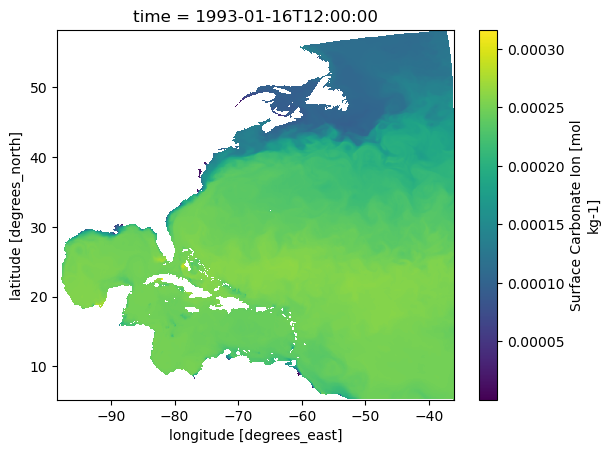

In [9]:
ds_regrid[variable_short].plot()

In [23]:
ds_old = xr.open_dataset('/Projects/CEFI/regional_mom6/cefi_portal/northwest_atlantic/full_domain/hindcast/monthly/regrid/r20230520/tob.nwa.full.hcast.monthly.regrid.r20230520.199301-201912.nc')

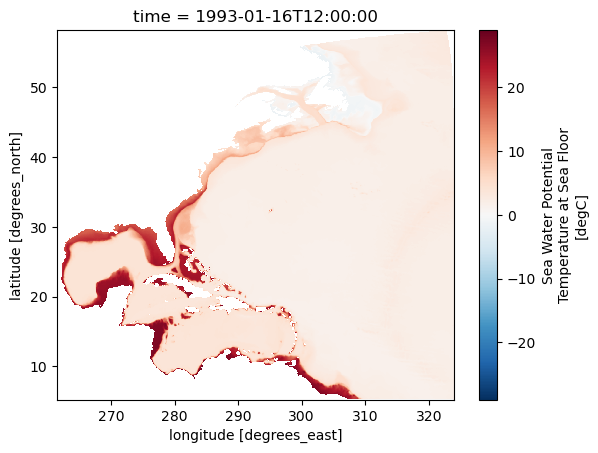

In [25]:
ds_old.tob.isel(time=0).plot()

In [27]:
ds_old.tob.isel(time=0)

<xarray.DataArray 'tob' (lat: 844, lon: 774)> Size: 3MB
[653256 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 7kB 5.273 5.335 5.398 5.461 ... 58.04 58.1 58.16
  * lon      (lon) float64 6kB 261.6 261.6 261.7 261.8 ... 323.8 323.8 323.9
    time     datetime64[ns] 8B 1993-01-16T12:00:00
Attributes:
    units:          degC
    long_name:      Sea Water Potential Temperature at Sea Floor
    cell_methods:   area:mean yh:mean xh:mean time: mean
    cell_measures:  area: areacello
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_water_potential_temperature_at_sea_floor

In [29]:
ds_regrid['lon'] = ds_regrid['lon']+360.
ds_regrid.tob.isel(time=0)

<xarray.DataArray 'tob' (lat: 844, lon: 774)> Size: 3MB
dask.array<getitem, shape=(844, 774), dtype=float32, chunksize=(200, 200), chunktype=numpy.ndarray>
Coordinates:
    time     datetime64[ns] 8B 1993-01-16T12:00:00
  * lon      (lon) float64 6kB 261.6 261.6 261.7 261.8 ... 323.8 323.8 323.9
  * lat      (lat) float64 7kB 5.273 5.335 5.398 5.461 ... 58.04 58.1 58.16
Attributes:
    regrid_method:  bilinear
    units:          degC
    long_name:      Sea Water Potential Temperature at Sea Floor
    cell_methods:   area:mean yh:mean xh:mean time: mean
    cell_measures:  area: areacello
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_water_potential_temperature_at_sea_floor

In [ ]:
(ds_regrid.tob.isel(time=0)-ds_old.tob.isel(time=0)).plot()

In [17]:
ds_var

<xarray.Dataset> Size: 914MB
Dimensions:       (time: 324, nv: 2, yh: 845, xh: 775, yq: 846, xq: 776)
Coordinates:
  * nv            (nv) float64 16B 1.0 2.0
  * time          (time) datetime64[ns] 3kB 1993-01-16T12:00:00 ... 2019-12-1...
  * xh            (xh) float64 6kB -98.0 -97.92 -97.84 ... -36.24 -36.16 -36.08
  * yh            (yh) float64 7kB 5.273 5.352 5.432 5.511 ... 51.9 51.91 51.93
  * xq            (xq) float64 6kB -98.04 -97.96 -97.88 ... -36.2 -36.12 -36.04
  * yq            (yq) float64 7kB 5.233 5.312 5.392 5.472 ... 51.9 51.92 51.94
Data variables: (12/30)
    average_DT    (time) timedelta64[ns] 3kB dask.array<chunksize=(100,), meta=np.ndarray>
    average_T1    (time) datetime64[ns] 3kB dask.array<chunksize=(100,), meta=np.ndarray>
    average_T2    (time) datetime64[ns] 3kB dask.array<chunksize=(100,), meta=np.ndarray>
    time_bnds     (time, nv) datetime64[ns] 5kB dask.array<chunksize=(100, 2), meta=np.ndarray>
    tob           (time, yh, xh) float32 849MB dask.array<chunksize=(100, 200, 200), meta=np.ndarray>
    Coriolis      (yq, xq) float32 3MB ...
    ...            ...
    geolon_v      (yq, xh) float32 3MB ...
    sftof         (yh, xh) float32 3MB ...
    wet           (yh, xh) float32 3MB ...
    wet_c         (yq, xq) float32 3MB ...
    wet_u         (yh, xq) float32 3MB ...
    wet_v         (yq, xh) float32 3MB ...
Attributes: (12/28)
    NumFilesInSet:          1
    title:                  NWA12_COBALT_2023_04_kpo4-coastatten-physics
    associated_files:       areacello: 19930101.ocean_static.nc
    grid_type:              regular
    grid_tile:              N/A
    external_variables:     areacello
    ...                     ...
    cefi_ensemble_info:     N/A
    cefi_forcing:           N/A
    cefi_data_doi:          10.5281/zenodo.7893386
    cefi_paper_doi:         10.5194/gmd-16-6943-2023
    cefi_aux:               N/A
    cefi_ori_category:      ocean_monthly